<a href="https://colab.research.google.com/github/ValentinKarev/ML_for_DNK/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B2%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%BE%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B8_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
supervision==0.9.0

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!mkdir {HOME}/images
!mkdir {HOME}/videos

In [ ]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 10

In [ ]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

In [ ]:
video_paths

[PosixPath('/content/videos/2023-10-13 20-30-22.mp4'),
 PosixPath('/content/videos/2023-10-25 21-46-14.mp4')]

In [ ]:
TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = [video_paths[1]], [video_paths[0]]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 1010


In [ ]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 6
SAMPLE_GRID_SIZE = (2, 3)
SAMPLE_PLOT_SIZE = (16, 16)

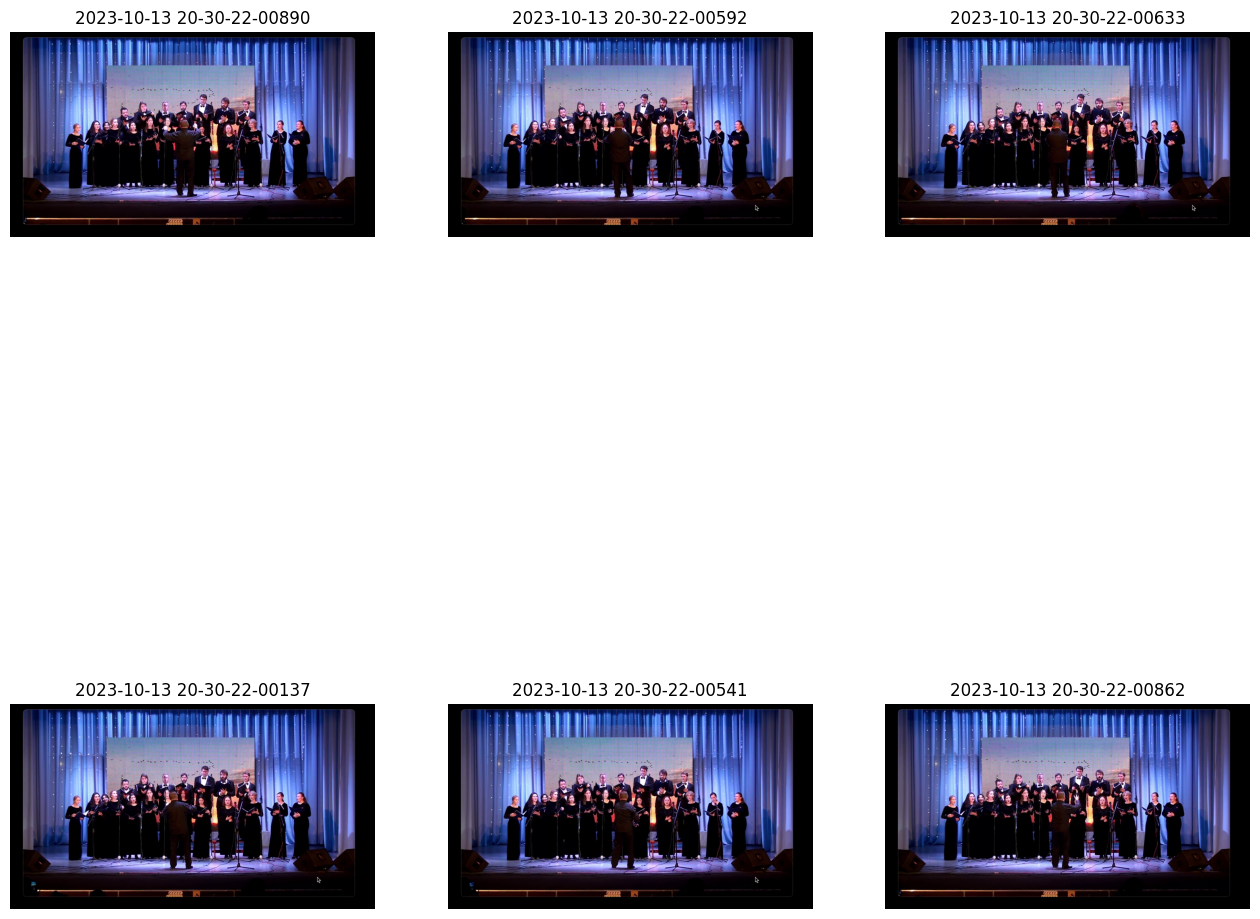

In [ ]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [ ]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "dildo": "target"
})

In [ ]:
DATASET_DIR_PATH = f"{HOME}/dataset"

In [ ]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Labeling /content/images/2023-10-13 20-30-22-00890.png:   0%|          | 0/1010 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Labeling /content/images/2023-10-13 20-30-22-00240.png:  28%|██▊       | 278/1010 [12:03<57:44,

In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

123

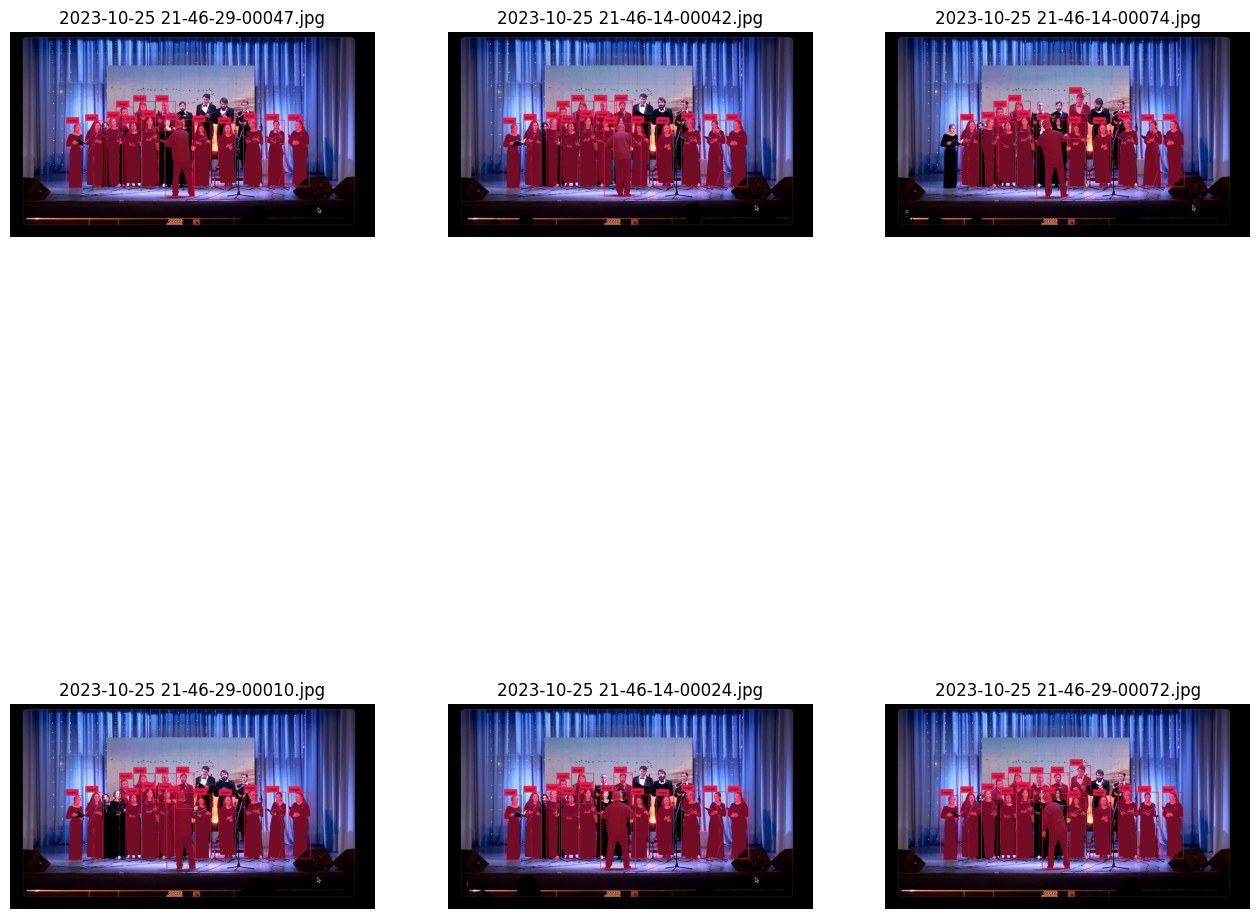

In [ ]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [ ]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=15)

/content


100%|██████████| 6.23M/6.23M [00:00<00:00, 282MB/s]
New https://pypi.org/project/ultralytics/8.0.201 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, aug

In [ ]:
# %cd {HOME}

# from IPython.display import Image

# Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


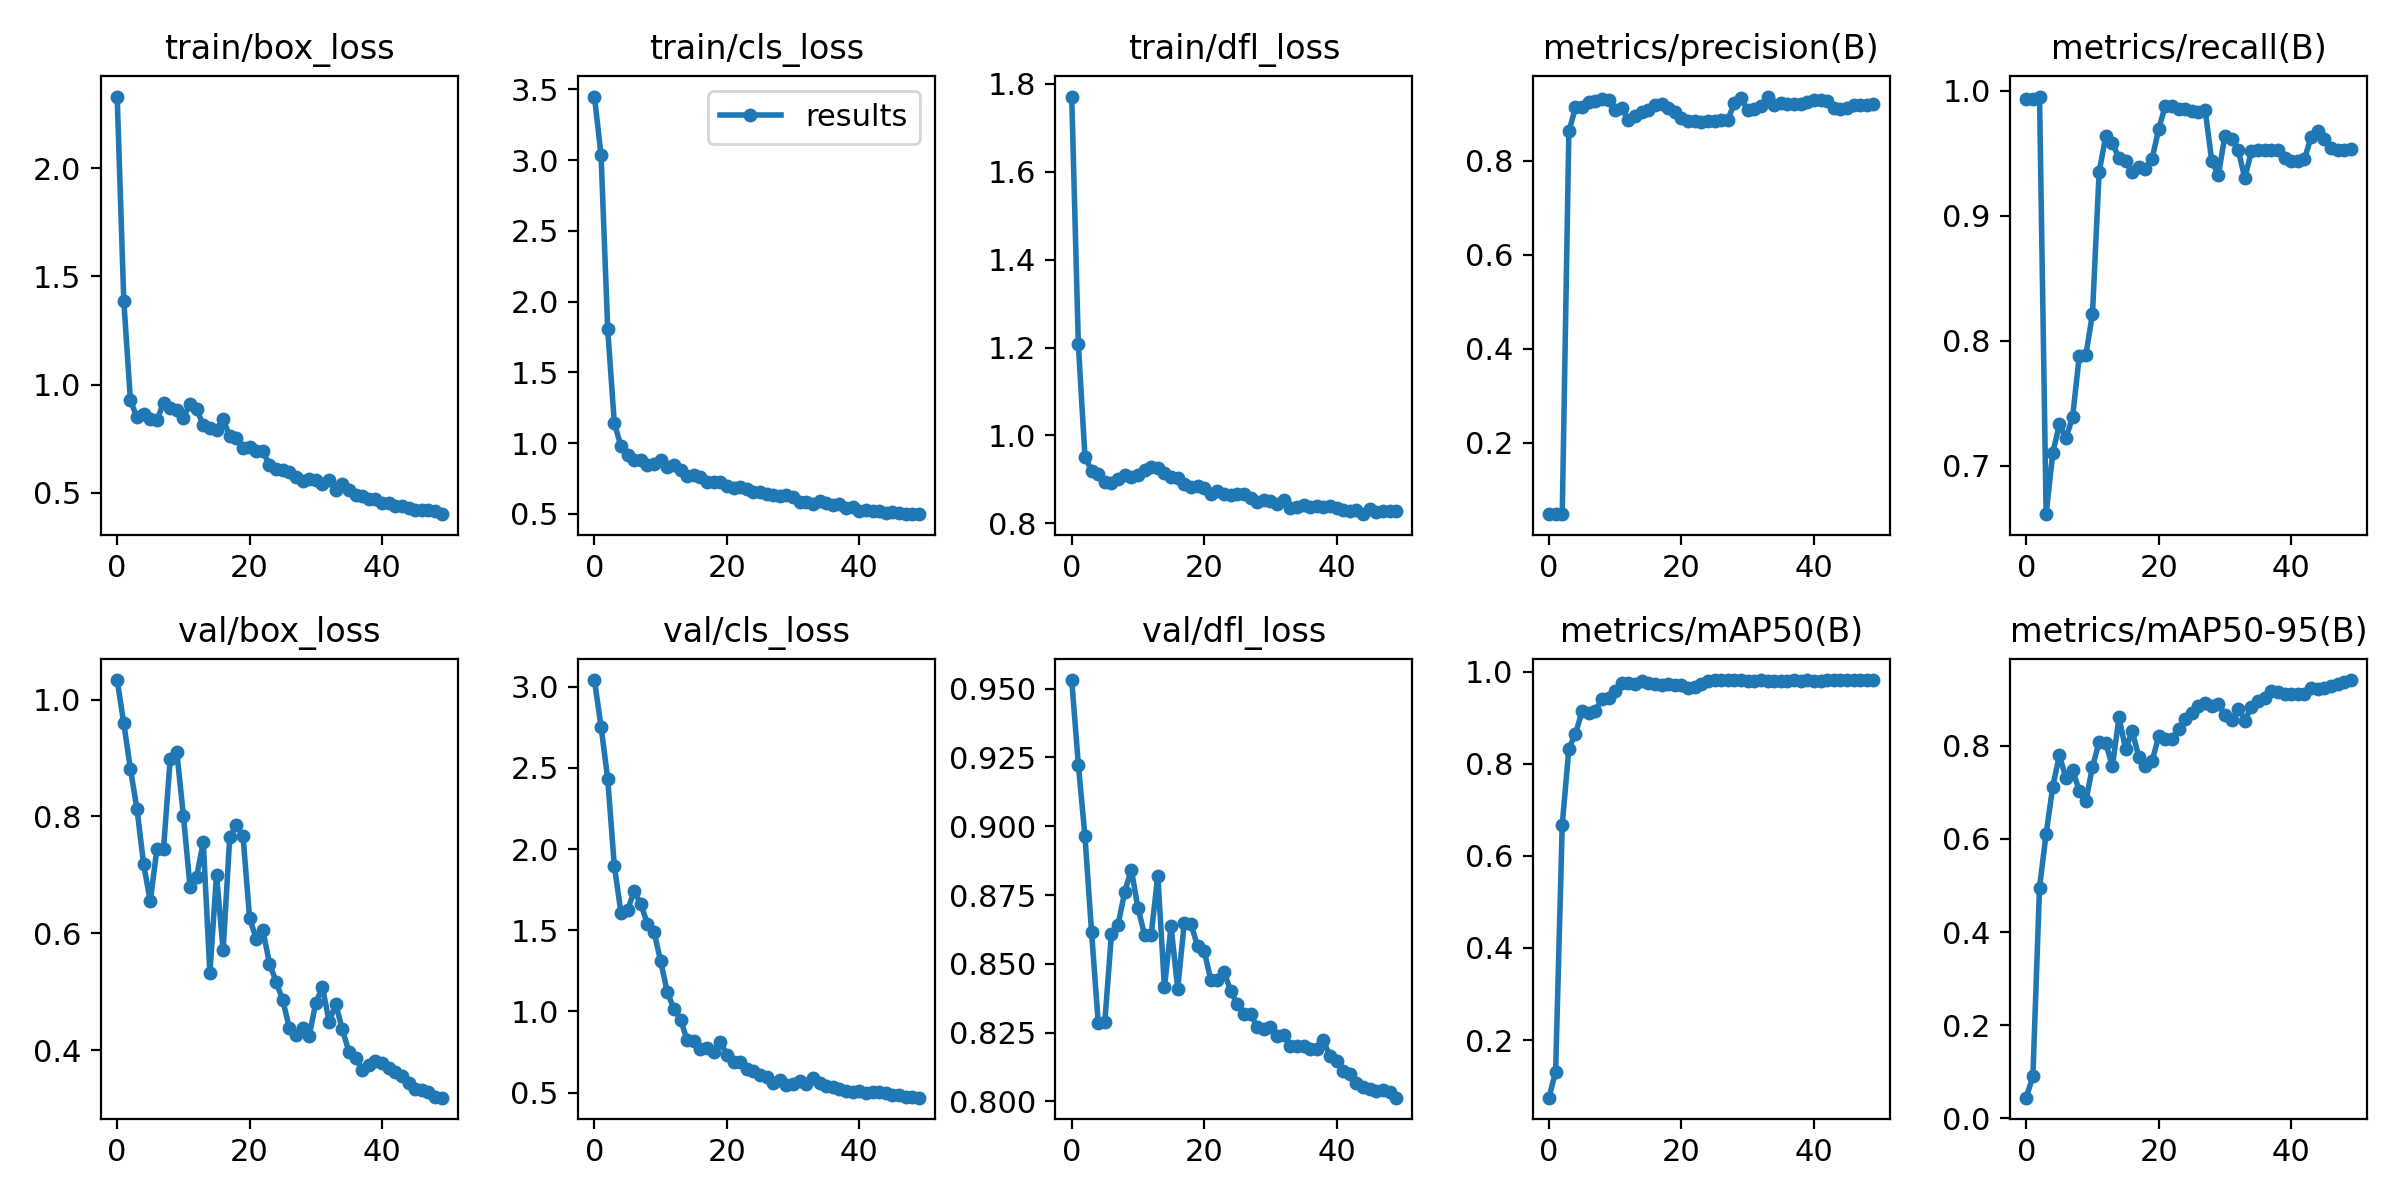

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


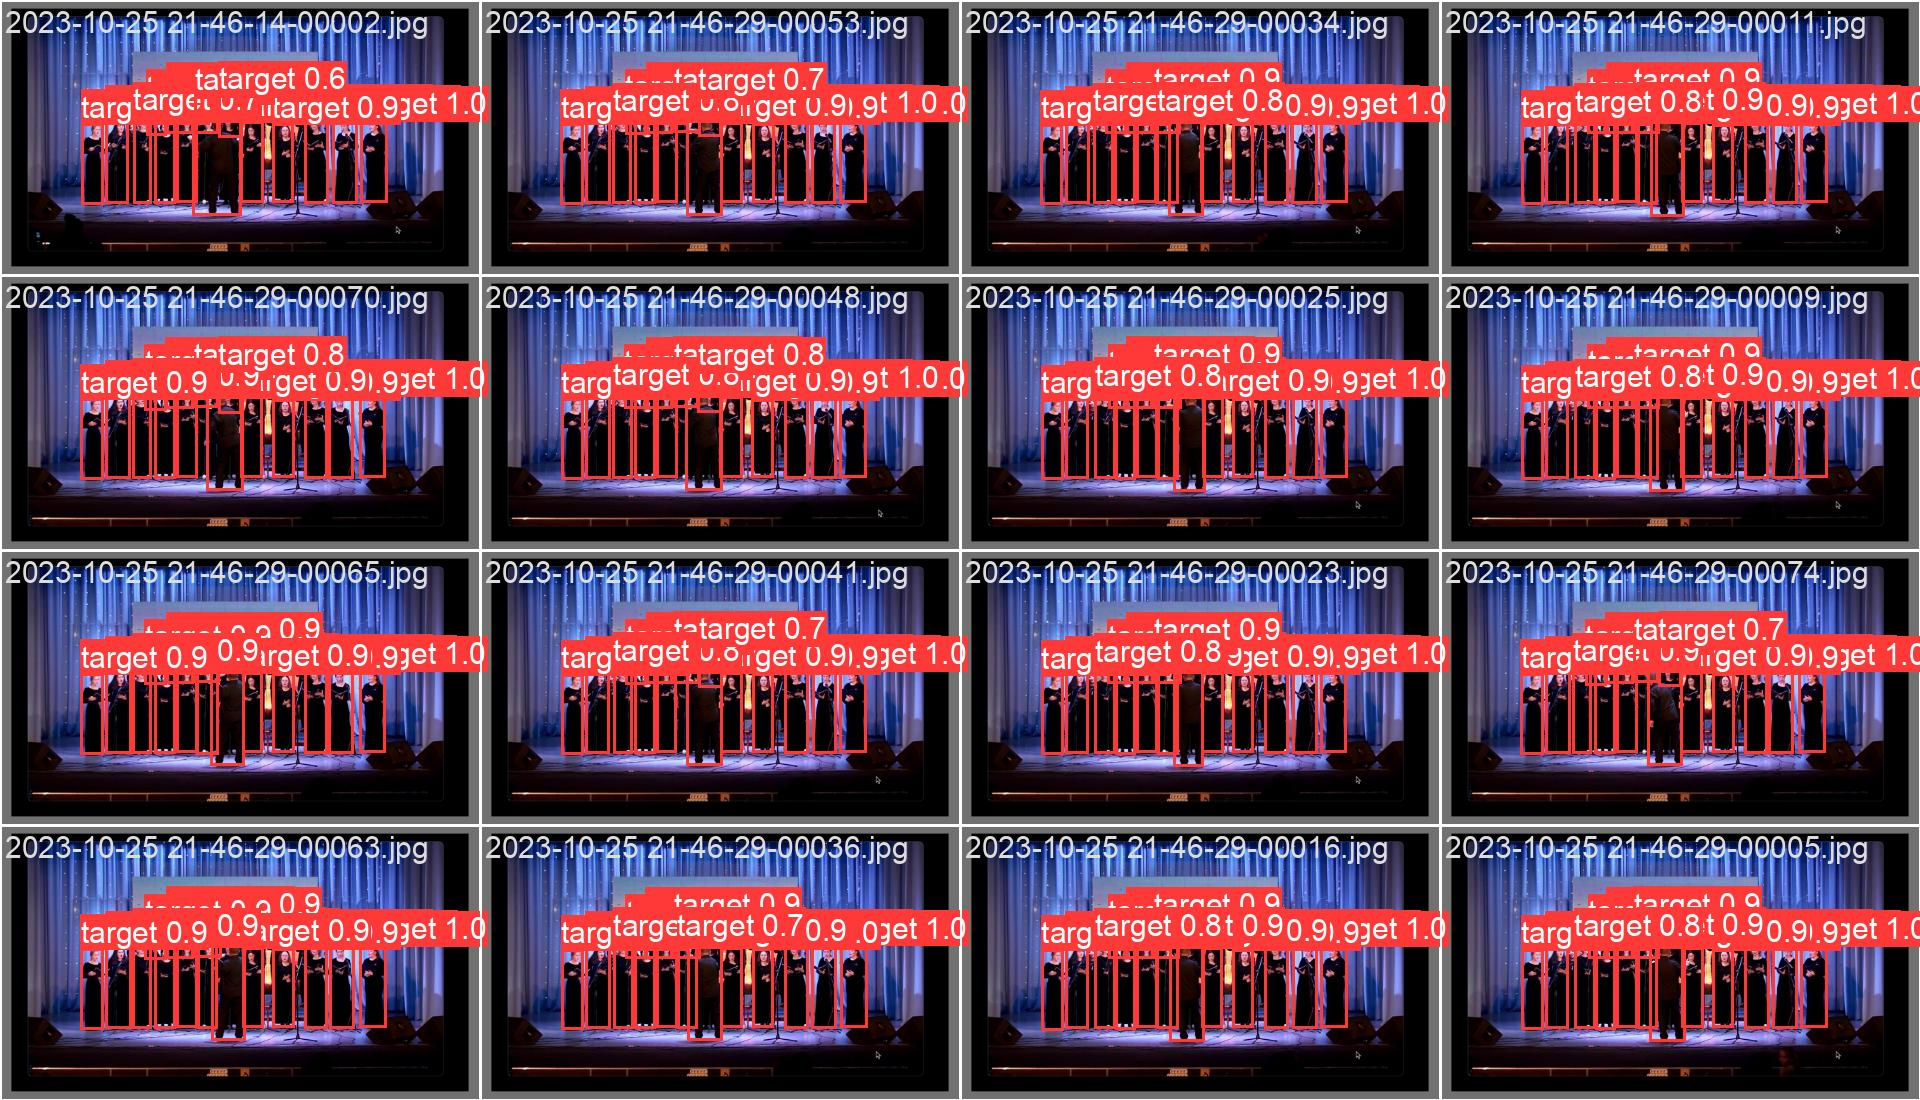

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
INPUT_VIDEO_PATH = str(TEST_VIDEO_PATHS[0])
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

In [ ]:
#fix
INPUT_VIDEO_PATH="/content/videos/2023-10-13\ 20-29-37.mp4"

In [ ]:
#temporal fix
import locale
locale.getpreferredencoding = lambda: "UTF-8" #"utf-8"

In [ ]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

2023-10-25 15:25:25.873310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 15:25:25.873366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 15:25:25.873413: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

video 1/1 (1/1154) /content/videos/2023-10-13 20-29-37.mp4: 384x640 14 targets, 101.9ms
video 1/1 (2/1154) /content/videos/2023-10-13 20-29-37.mp4: 384x640 13 targets, 9.5ms
video 1/1 (3/1154) /c